In [1]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, random_split
import random

In [2]:
# Define the categories and the paths to datasets
cates = ['Acne', 'Eczema', 'Rosacea', 'Psoriasis', 'Seborrheic Dermatitis', 'Perioral Dermatitis', 'Tinea Faciei']

checkpoint_path = r'C:\Users\Josh\Desktop\tool-backend\AlexnetModel\54percent.pth'
data_dir = r'C:\Users\Josh\Desktop\tool-backend\MyDataset'
BATCH_SIZE = 32
INPUT_SIZE = (227, 227)  

# Set a seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)



In [3]:
# Define a simple transform without normalization for calculating the mean and std
transform_no_normalization = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.ToTensor()  
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform_no_normalization)

# Calculate the split sizes
train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = int(0.2 * len(full_dataset))    # 20% for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining 10% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training set size: 2450
Validation set size: 700
Test set size: 350


In [4]:
# Function to calculate mean and std in a single pass
def calculate_mean_std(loader):
    mean = torch.zeros(3)
    var = torch.zeros(3)
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        total_images += batch_samples
        batch_mean = images.mean([0, 2, 3])
        batch_var = images.var([0, 2, 3])

        mean += batch_mean * batch_samples
        var += batch_var * batch_samples

    mean /= total_images
    var /= total_images
    std = torch.sqrt(var)

    return mean, std

# Calculate the mean and std for the training set
mean, std = calculate_mean_std(train_loader)
print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

Calculated mean: tensor([0.6069, 0.4542, 0.4119])
Calculated std: tensor([0.2440, 0.2034, 0.1986])


In [5]:
# Now you can use the calculated mean and std for normalization in your transforms
transform_train = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(-10, -10)),
        transforms.RandomRotation(degrees=(10, 10)),
        transforms.RandomRotation(degrees=(-20, -20)),
        transforms.RandomRotation(degrees=(20, 20))
    ]),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  
])

transform_val_test = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Use calculated mean and std
])

# Reload the datasets with the new transforms
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=data_dir, transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=data_dir, transform=transform_val_test)

# Split the datasets again
train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# Get a batch of images and labels from the DataLoader
images, labels = next(iter(train_loader))
print(images.shape)  


torch.Size([32, 3, 227, 227])


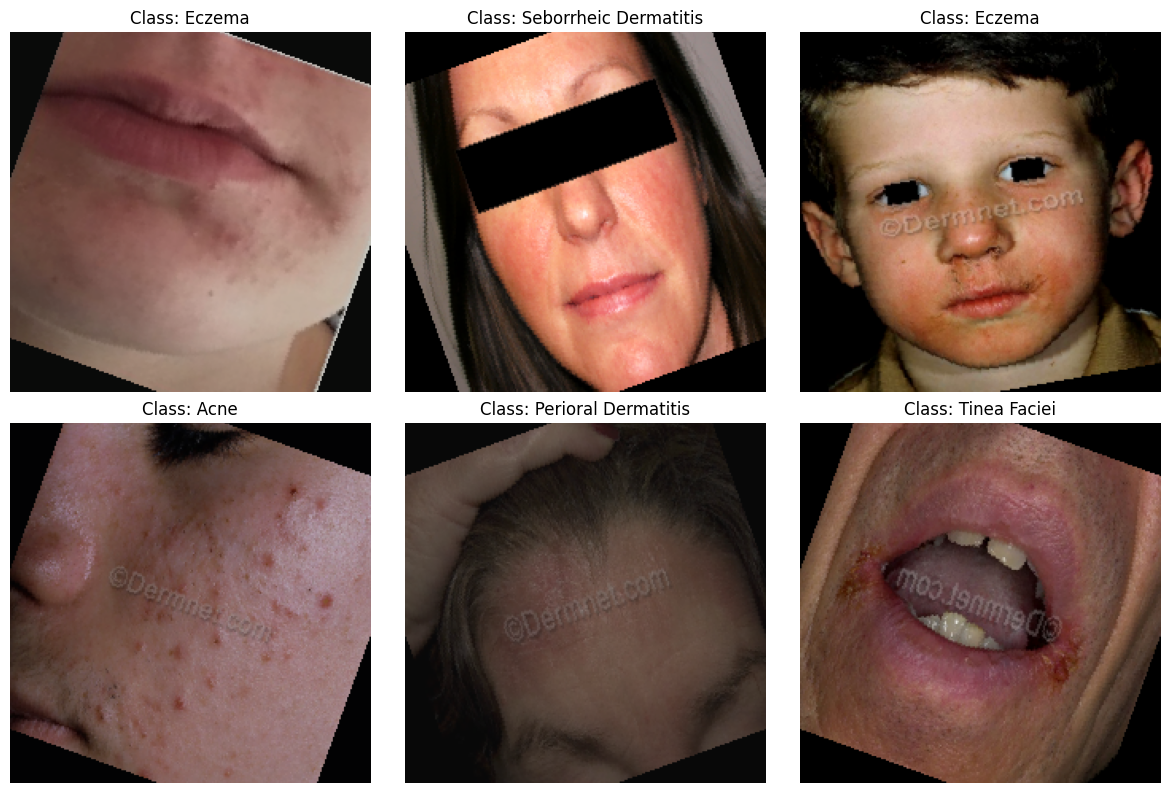

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize the image for visualization
def unnormalize(image, mean, std):
    image = image.numpy().transpose((1, 2, 0))  # Move channels to the last dimension
    mean = np.array(mean)
    std = np.array(std)
    image = std * image + mean  # Reverse the normalization
    image = np.clip(image, 0, 1)  # Clip values to [0, 1] for proper display
    return image

# Visualize a batch of images from the train_loader
def visualize_loader(loader, mean, std, class_names, num_images=6):
    # Get a batch of images
    data_iter = iter(loader)
    images, labels = next(data_iter)  # Get the first batch


    # Plot the images
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 3, i+1)
        image = unnormalize(images[i], mean, std)  # Unnormalize the image for display
        plt.imshow(image)
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use this function to visualize a batch of images
visualize_loader(train_loader, mean=mean.tolist(), std=std.tolist(), class_names=cates)


In [8]:
from torchsummary import summary

class AlexNetFC6(nn.Module):
    def __init__(self):
        super(AlexNetFC6, self).__init__()
        alexnet = models.alexnet(pretrained=False)
        self.features = alexnet.features
        self.pooling = nn.AdaptiveAvgPool2d((6, 6))
        self.fc6 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc6(x)
        return x


alexnet_fc6 = AlexNetFC6()
alexnet_fc6.load_state_dict(torch.load(checkpoint_path), strict=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_fc6.to(device)
alexnet_fc6.eval()  

# summary(alexnet_fc6, input_size=(3, 227, 227))


c:\Users\Josh\Desktop\tool-backend\tool\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Josh\Desktop\tool-backend\tool\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Josh\AppData\Local\Temp\ipykernel_28384\3267272553.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for

AlexNetFC6(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pooling): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc6): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

In [9]:
# Feature extraction function (up to fc6)
def extract_features(data_loader, model):
    features = []
    labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for images, target_labels in data_loader:
            images = images.to(device)
            
            # Extract features using the custom AlexNet model (up to fc6)
            output_features = model(images)
            
            # Append extracted features and labels to the list
            features.append(output_features.cpu().numpy())
            labels.append(target_labels.cpu().numpy())
    
    # Concatenate features and labels from all batches
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [10]:
# Extract features from the datasets
train_features, y_train = extract_features(train_loader, alexnet_fc6)
val_features, y_val = extract_features(val_loader, alexnet_fc6)
test_features, y_test = extract_features(test_loader, alexnet_fc6)


In [11]:
import joblib

# Scale the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
joblib.dump(scaler, 'scaler.joblib')

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

In [12]:
# Convert labels to class indices (if using one-hot encoding or categorical)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(f"Shape of train_features: {train_features.shape}")
print(f"Shape of y_train: {y_train.shape}")

print(f"Shape of val_features: {val_features.shape}")
print(f"Shape of y_val: {y_val.shape}")

print(f"Shape of test_features: {test_features.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of train_features: (2450, 4096)
Shape of y_train: (2450,)
Shape of val_features: (700, 4096)
Shape of y_val: (700,)
Shape of test_features: (350, 4096)
Shape of y_test: (350,)


In [13]:
# Train XGBoost classifier
dtrain = xgb.DMatrix(train_features, label=y_train)
dval = xgb.DMatrix(val_features, label=y_val)
dtest = xgb.DMatrix(test_features, label=y_test)

# Verify if DMatrix creation was successful
print(f"Train DMatrix: {dtrain.num_row()} rows, {dtrain.num_col()} columns")
print(f"Validation DMatrix: {dval.num_row()} rows, {dval.num_col()} columns")
print(f"Test DMatrix: {dtest.num_row()} rows, {dtest.num_col()} columns")


# Check class distribution in training data
from collections import Counter
print(f"Training class distribution: {Counter(y_train)}")


Train DMatrix: 2450 rows, 4096 columns
Validation DMatrix: 700 rows, 4096 columns
Test DMatrix: 350 rows, 4096 columns
Training class distribution: Counter({5: 364, 4: 362, 6: 359, 2: 347, 0: 344, 3: 340, 1: 334})


In [15]:
from sklearn.metrics import accuracy_score
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    learning_rate=0.02,
    max_depth=5,
    n_estimators=250,
    colsample_bytree=0.6,
    subsample=0.7,
    min_child_weight=4,
    gamma=0.4,
    reg_alpha=0.1,
    reg_lambda=1.8,
    objective='multi:softprob',
    num_class=len(cates),
    eval_metric='mlogloss',
    use_label_encoder=False,
    early_stopping_rounds=15
)

# Fit the model on the training data
xgb_model.fit(
    train_features,
    y_train,
    eval_set=[(val_features, y_val)],
    verbose=True
)

# Save the trained model
xgb_model.save_model('xgboost_model.json')

# Evaluate on the validation set
val_predictions = xgb_model.predict(val_features)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Evaluate on the test set
test_predictions = xgb_model.predict(test_features)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


c:\Users\Josh\Desktop\tool-backend\tool\lib\site-packages\xgboost\core.py:158: UserWarning: [08:17:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.93337
[1]	validation_0-mlogloss:1.92100
[2]	validation_0-mlogloss:1.90914
[3]	validation_0-mlogloss:1.89793
[4]	validation_0-mlogloss:1.88606
[5]	validation_0-mlogloss:1.87467
[6]	validation_0-mlogloss:1.86349
[7]	validation_0-mlogloss:1.85182
[8]	validation_0-mlogloss:1.84070
[9]	validation_0-mlogloss:1.83107
[10]	validation_0-mlogloss:1.82100
[11]	validation_0-mlogloss:1.81098
[12]	validation_0-mlogloss:1.80228
[13]	validation_0-mlogloss:1.79270
[14]	validation_0-mlogloss:1.78466
[15]	validation_0-mlogloss:1.77554
[16]	validation_0-mlogloss:1.76676
[17]	validation_0-mlogloss:1.75840
[18]	validation_0-mlogloss:1.75019
[19]	validation_0-mlogloss:1.74243
[20]	validation_0-mlogloss:1.73412
[21]	validation_0-mlogloss:1.72653
[22]	validation_0-mlogloss:1.71951
[23]	validation_0-mlogloss:1.71218
[24]	validation_0-mlogloss:1.70507
[25]	validation_0-mlogloss:1.69815
[26]	validation_0-mlogloss:1.69145
[27]	validation_0-mlogloss:1.68490
[28]	validation_0-mlogloss:1.6

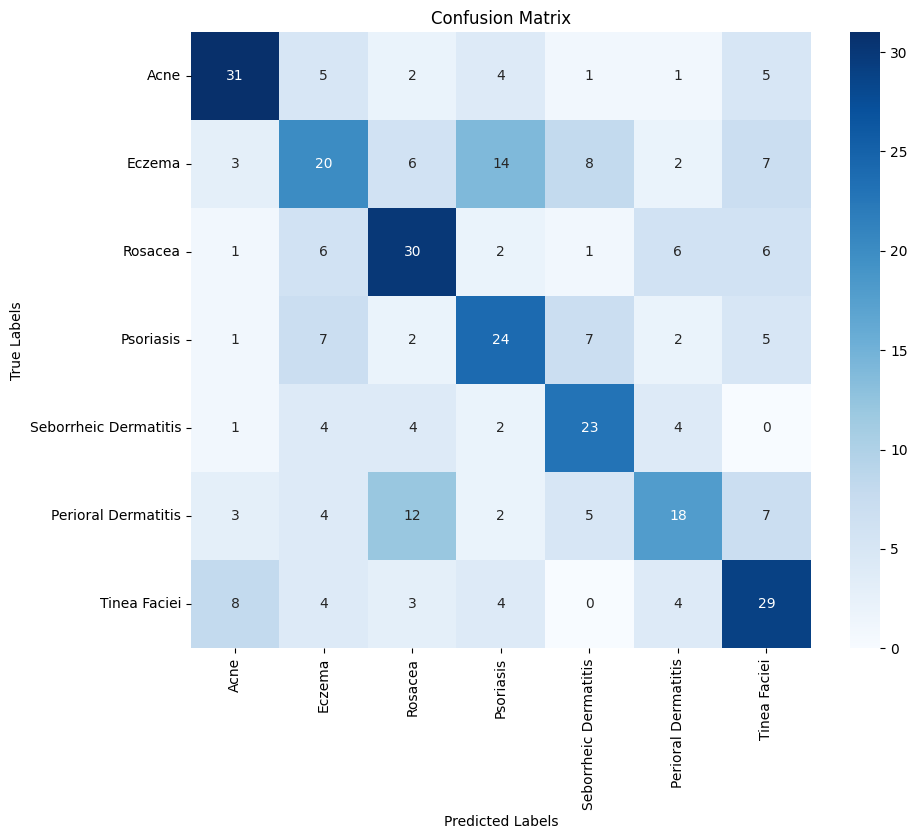

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cates, yticklabels=cates)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
